In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import rampy as rp

import sklearn
from sklearn.externals import joblib

import neuravi

# Loading dataset

Dataset has been prepared before

In [2]:
d = neuravi.Data("./data/")

# we have the chemical composition as X train/valid/test, but also the temperature

chimie_train = d.X_train[:,0:14]
temperature_train = d.X_train[:,14].reshape(-1,1)

chimie_valid = d.X_valid[:,0:14]
temperature_valid = d.X_valid[:,14].reshape(-1,1)

chimie_test = d.X_test[:,0:14]
temperature_test = d.X_test[:,14].reshape(-1,1)

# rescale chimie between 0 and 1

chimie_train = chimie_train/chimie_train.sum(axis=1).reshape(-1,1)
chimie_valid = chimie_valid/chimie_valid.sum(axis=1).reshape(-1,1)
chimie_test = chimie_test/chimie_test.sum(axis=1).reshape(-1,1)

In [34]:
name_in = "TVF_layer_1units_100it_100000"

figure_name = "TVF.pdf"

In [35]:
from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        
        # Get prediction tensor
        pred = restored_graph.get_tensor_by_name('visco_pred:0')
        
        # make predictions
        train_pred_out = sess.run(pred, feed_dict={chimie_placeholder: chimie_train, 
                                                     T_placeholder: temperature_train})
        
        valid_pred_out = sess.run(pred, feed_dict={chimie_placeholder: chimie_valid, 
                                                     T_placeholder: temperature_valid})
        
        test_pred_out  = sess.run(pred, feed_dict={chimie_placeholder: chimie_test,
                                                     T_placeholder: temperature_test})
        print('Predictions done')


Restoring...
INFO:tensorflow:Restoring parameters from model/TVF_layer_1units_100it_100000/variables/variables
Ok
Predictions done


In [36]:
print("RMSE %.2f" %mean_squared_error(d.y_train, train_pred_out))

RMSE 0.17


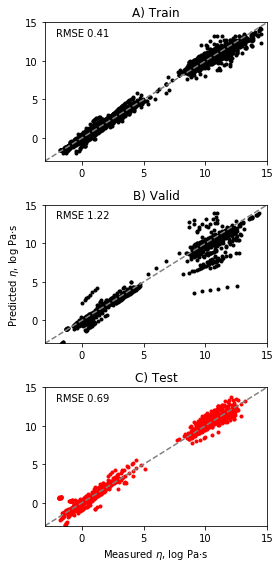

In [37]:
plt.figure(figsize=(4,8))
plt.subplot(3,1,1)
plt.title("A) Train")
plt.plot(d.y_train, train_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_train, train_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.subplot(3,1,2)
plt.title("B) Valid")
plt.plot(d.y_valid, valid_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_valid, valid_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.ylabel("Predicted $\eta$, log Pa$\cdot$s")

plt.subplot(3,1,3)
plt.title("C) Test")
plt.plot(d.y_test, test_pred_out,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_test, test_pred_out)),xy=(0.05,0.9),xycoords="axes fraction")

plt.xlabel("Measured $\eta$, log Pa$\cdot$s")

plt.tight_layout()

plt.savefig(figure_name)

# Quantification of RMSE

In [38]:
MSE_NN_train = np.sqrt(mean_squared_error(d.y_train, train_pred_out))
MSE_NN_valid = np.sqrt(mean_squared_error(d.y_valid, valid_pred_out))
MSE_NN_test = np.sqrt(mean_squared_error(d.y_test, test_pred_out))

print("training, validation and testing RMSE with neural nets")
print(MSE_NN_train)
print(MSE_NN_valid)
print(MSE_NN_test)

training, validation and testing RMSE with neural nets
0.4085895224662138
1.221224446871074
0.68876471500816


# Calculating Ae

In [39]:
import pandas as pd
#
dataset_post = pd.read_csv("./data/rhyolite_for_post_analysis.csv")

to_pred_c= dataset_post.loc[:,"sio2":"h2o"].values
to_pred_c = to_pred_c/to_pred_c.sum(axis=1).reshape(-1,1)
print("Chemistry array loaded:")
print(to_pred_c)

to_pred_T= dataset_post.loc[:,"T"]
print("Temperature DataFrame loaded:")
print(to_pred_T.head())

to_pred_n= dataset_post.loc[:,"viscosity"]
print("Viscosity DataFrame loaded:")
print(to_pred_n.head())

Chemistry array loaded:
[[0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         

In [53]:
from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        
        # Get prediction tensors
        pred = restored_graph.get_tensor_by_name('visco_pred:0')
        #a_ = restored_graph.get_tensor_by_name('A:0')
        b_ = restored_graph.get_tensor_by_name('B:0')
        t1_ = restored_graph.get_tensor_by_name('T1:0')
        
        # make predictions
        visco_p,b_p,t1_p  = sess.run([pred,b_,t1_], 
                                          feed_dict={chimie_placeholder: to_pred_c, 
                                                     T_placeholder: to_pred_T.values.reshape(-1,1)})
        
        print('Predictions done')


Restoring...
INFO:tensorflow:Restoring parameters from model/TVF_layer_1units_100it_100000/variables/variables
Ok
Predictions done


In [45]:
dataset_post

,Name,sio2,tio2,al2o3,feot,mno,bao,sro,mgo,cao,li2o,na2o,k2o,p2o5,h2o,T,viscosity,ScTg,Tg,Source
0,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1112.4,12.05,Le Losq and Neuville 2013,NaN,NaN
1,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1132.8,11.61,Le Losq and Neuville 2013,NaN,NaN
2,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1148.4,11.31,Le Losq and Neuville 2013,NaN,NaN
3,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1170.5,10.98,Le Losq and Neuville 2013,NaN,NaN
4,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1185.0,10.65,Le Losq and Neuville 2013,NaN,NaN
5,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1190.3,10.58,Le Losq and Neuville 2013,NaN,NaN
6,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1201.7,10.38,Le Losq and Neuville 2013,NaN,NaN
7,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1209.5,10.22,Le Losq and Neuville 2013,NaN,NaN
8,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1211.5,10.21,Le Losq and Neuville 2013,NaN,NaN
9,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1227.4,9.91,Le Losq and Neuville 2013,NaN,NaN


0.43875450727493


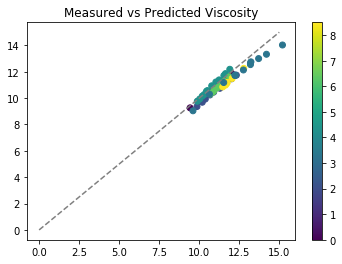

In [46]:
plt.scatter(to_pred_n,visco_p[0],c=dataset_post.k2o)
plt.colorbar()
plt.plot([0,15],[0,15],"--",color="grey")
plt.title("Measured vs Predicted Viscosity")
print(np.sqrt(mean_squared_error(visco_p[0], to_pred_n)))

In [48]:
visco_p

[array([[11.837589 ],
        [11.428139 ],
        [11.127399 ],
        [10.718559 ],
        [10.460672 ],
        [10.368368 ],
        [10.173265 ],
        [10.04241  ],
        [10.009193 ],
        [ 9.749905 ],
        [ 9.756327 ],
        [ 9.261556 ],
        [ 9.362604 ],
        [ 9.689213 ],
        [ 9.931807 ],
        [10.240166 ],
        [10.455952 ],
        [10.746614 ],
        [11.1217785],
        [11.466278 ],
        [11.744598 ],
        [ 9.761924 ],
        [ 9.931669 ],
        [10.1511965],
        [10.271924 ],
        [10.515288 ],
        [10.5727625],
        [10.935584 ],
        [11.224608 ],
        [11.3817625],
        [11.713056 ],
        [11.860425 ],
        [12.188645 ],
        [10.307516 ],
        [10.472628 ],
        [10.600956 ],
        [10.80192  ],
        [11.004    ],
        [11.281811 ],
        [11.624159 ],
        [10.854235 ],
        [10.989639 ],
        [11.057198 ],
        [11.117491 ],
        [11.191982 ],
        [1

Text(0.5,1,'Measured vs Predicted Entropy')

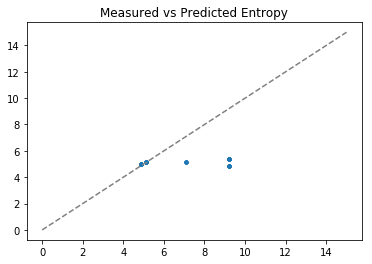

In [19]:
plt.plot(dataset_post.loc[:,"ScTg"],sctg_p,".")
plt.plot([0,15],[0,15],"--",color="grey")
plt.title("Measured vs Predicted Entropy")

Text(0.5,1,'Measured vs Predicted Glass Transition Temperature')

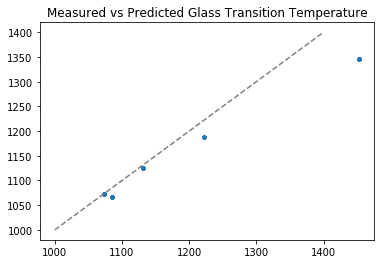

In [20]:
plt.plot(dataset_post.loc[:,"Tg"],tg_p,".")
plt.plot([1000,1400],[1000,1400],"--",color="grey")
plt.title("Measured vs Predicted Glass Transition Temperature")

# Continue Training

In [35]:
NEPOCH = 1000
loss_train = np.zeros(NEPOCH)
loss_valid = np.zeros(NEPOCH)

from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        n_placeholder = restored_graph.get_tensor_by_name('viscosity:0')
        
        # Get loss
        opt = restored_graph.get_collection('optimizer')
        loss = restored_graph.get_tensor_by_name('loss:0')
        
        for i in range(NEPOCH):
        
            # train
            sess.run(opt,feed_dict={chimie_placeholder: chimie_train, 
                                 T_placeholder: temperature_train.reshape(-1,1),
                                 n_placeholder: d.y_train.reshape(-1,1)})
            # calculate loss
            loss_train[i] = sess.run(loss,feed_dict={chimie_placeholder: chimie_train, 
                                 T_placeholder: temperature_train.reshape(-1,1),
                                 n_placeholder: d.y_train.reshape(-1,1)})
            loss_valid[i] = sess.run(loss,feed_dict={chimie_placeholder: chimie_valid, 
                                 T_placeholder: temperature_valid.reshape(-1,1),
                                 n_placeholder: d.y_valid.reshape(-1,1)})
        
            if (i % 500 == 0):
                print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
        print('Training done')


Restoring...
INFO:tensorflow:Restoring parameters from model/layer1units200it10000/variables/variables
Ok


ValueError: could not convert string to float: b'\n\x0b\n\x04loss\x15\xa5%TD'

In [ ]:
tf.nn.l2_loss()